## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [3]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


/tmp/ipykernel_138108/2637987050.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

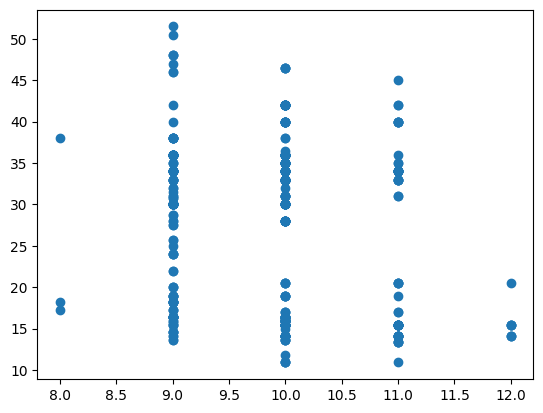

In [4]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

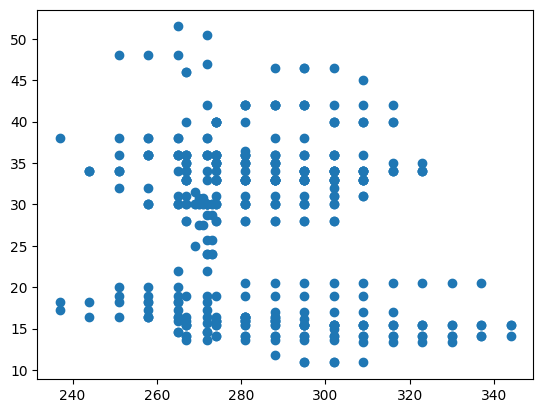

In [5]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [6]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))

print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077526
-0.1667332249274541


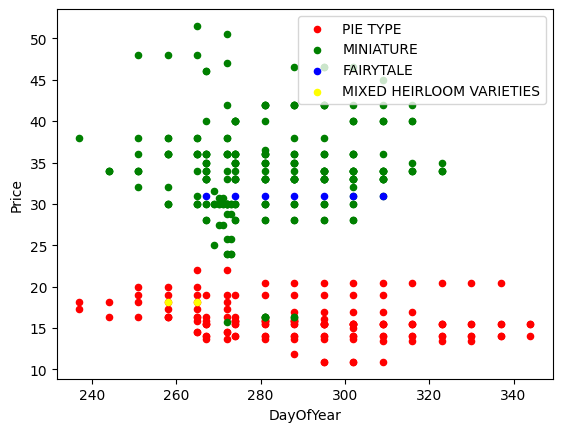

In [7]:
# Define the color to use to plot the pumpkins
colors = ['red','green','blue','yellow']

# Plot the price vs Day of year for the pumpkins using a diffenrent color for each variety
ax = None

for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    #ax=plt.scatter('DayOfYear','Price',data=df,c=colors[i],label=var)
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<Axes: xlabel='Variety'>

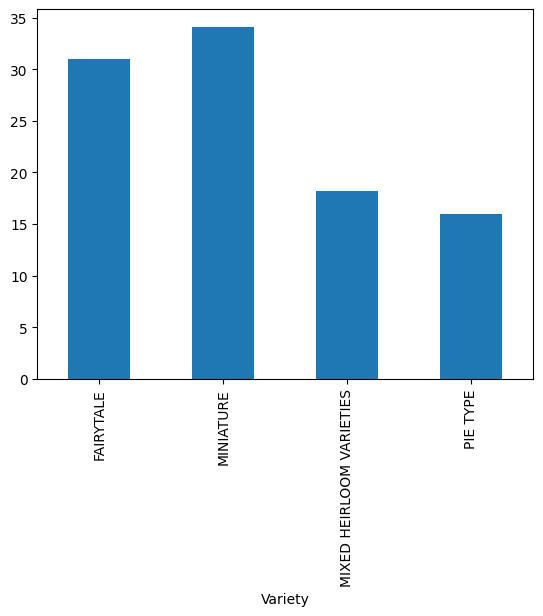

In [8]:
new_pumpkins.groupby(new_pumpkins['Variety'])['Price'].mean().plot(kind='bar')

<Axes: xlabel='DayOfYear', ylabel='Price'>

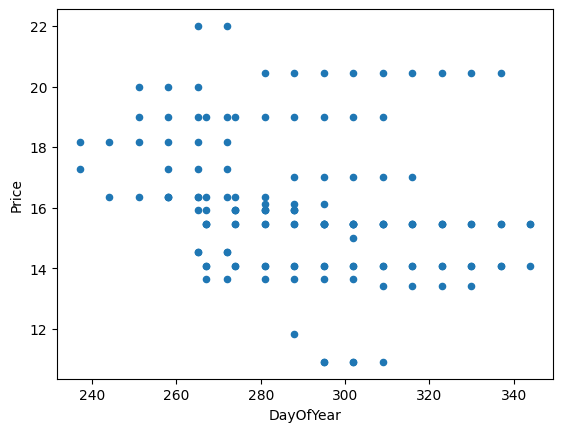

In [9]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear','Price')

In [10]:
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
print(pie_pumpkins['Month'].corr(pie_pumpkins['Price']))

-0.2669192282197318
-0.23841413206125747


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [12]:
# Get the Dayofyear and price in separate array

x=pie_pumpkins['DayOfYear']
y = pie_pumpkins['Price']
print(x.shape)
x.to_numpy().reshape(-1,1)
print(x.shape)

(144,)
(144,)


In [13]:
X=pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']
print(x.shape)

(144,)


In [14]:
# Split the data into training and testing data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [15]:
# Create a linear Regression objet
lin_reg=LinearRegression()

# Train the model using our training data
lin_reg.fit(X_train,y_train)

LinearRegression()

In [16]:
# Predicting on test data
y_pred = lin_reg.predict(X_test)
y_pred[:5]

array([16.21096253, 16.73652536, 16.08833121, 15.35254325, 15.96569988])

In [17]:
y_test[:5]

77     16.136364
704    16.363636
712    20.454545
191    13.409091
981    19.000000
Name: Price, dtype: float64

In [18]:
# Calculate the Root mean squared error
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print(f'Root mean square error {rmse:3.3} ({rmse/np.mean(y_pred)*100:3.3}%) ')


Root mean square error 2.77 (17.2%) 


In [19]:
# Calculate the coefficient of determination
score = lin_reg.score(X_train,y_train)
print('Model Determination:', score)

Model Determination: 0.04460606335028361


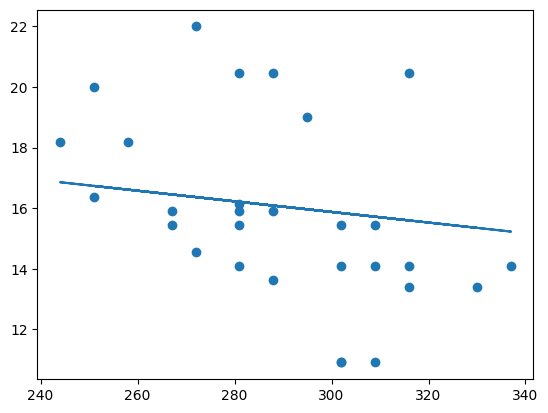

In [20]:
# Create a scatter plot using test data
plt.scatter(X_test,y_test)

# Add a line to the plot with the predictions
plt.plot(X_test,y_pred)

In [21]:
# Print the slope and intercept
print(f'y={lin_reg.coef_[0]}x + {lin_reg.intercept_}')

y=-0.017518760953105x + 21.133734359909326


In [22]:
lin_reg.predict([[256]])

array([16.64893156])

Root mean squared error 2.73 (17.0%)


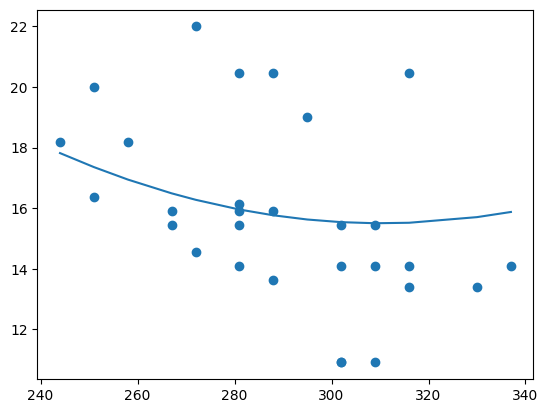

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Build a polynomialRegression Pipeline
pipeline = make_pipeline(PolynomialFeatures(2),LinearRegression())

# Use the pipeline to build/Fit the model
pipeline.fit(X_train,y_train)

# test the model with our test data
pred = pipeline.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Root mean squared error {rmse:3.3} ({rmse/np.mean(pred)*100:3.3}%)' )

# Plot the results
plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))




In [24]:
score= pipeline.score(X_train,y_train)
print('Model Determination:', score)

Model Determination: 0.07639977655280139


In [28]:
# convert the variety into categorical features
pd.get_dummies(new_pumpkins['Variety'],dtype=np.int32)

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,0,0,0,1
71,0,0,0,1
72,0,0,0,1
73,0,0,0,1
74,0,0,0,1
...,...,...,...,...
1738,0,1,0,0
1739,0,1,0,0
1740,0,1,0,0
1741,0,1,0,0


In [29]:
# Get the X values as new dataframe with the month column along with the variety converted into categorical features
X = pd.get_dummies(new_pumpkins['Variety'],dtype=np.int32)

# Get the y value as the price
y=new_pumpkins['Price']

In [30]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Create a Linear Regression Object

ling_reg = LinearRegression()

# Train the model using test data
lin_reg.fit(X_train,y_train)

#Predict(Test) the model on the test data
pred= lin_reg.predict(X_test)

#Root mean suqared error
rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Root mean squared error {rmse:3.3} ({rmse/np.mean(pred)*100}%)')

# Calculate the coeeficient of determination
score = lin_reg.score(X_train,y_train)
print('Model Dteremination',score)





Root mean squared error 5.24 (19.688248599003614%)
Model Dteremination 0.774085281105197


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


In [34]:
# Get the X values as new dataframe with the month column along with the variety converted into categorical features
X = pd.get_dummies(new_pumpkins['Variety'],dtype=np.int32)\
                .join(new_pumpkins['Month'])\
                .join(pd.get_dummies(new_pumpkins['City'],dtype=np.int32))\
                .join(pd.get_dummies(new_pumpkins['Package'],dtype=np.int32))


# Get the y value as the price
y=new_pumpkins['Price']

In [42]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Create a Linear Regression Object

ling_reg = LinearRegression()

# Train the model using test data
lin_reg.fit(X_train,y_train)

#Predict(Test) the model on the test data
pred= lin_reg.predict(X_test)

#Root mean suqared error
rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Root mean squared error {rmse:3.3} ({rmse/np.mean(pred)*100}%)')

# Calculate the coeeficient of determination
score = lin_reg.score(X_train,y_train)
print('Model Dteremination',score)





Root mean squared error 2.84 (10.549210915090832%)
Model Dteremination 0.9401401953107826


In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
#Build a polynomialRegression Pipeline
pipeline = make_pipeline(PolynomialFeatures(2),LinearRegression())

# Use the pipeline to build/Fit the model
pipeline.fit(X_train,y_train)

# test the model with our test data
pred = pipeline.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Root mean squared error {rmse:3.3} ({rmse/np.mean(pred)*100:3.3}%)' )

# Plot the results
#plt.scatter(X_test,y_test)
#plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

# Calculate the coeeficient of determination
score = pipeline.score(X_train,y_train)
print('Model Dteremination',score)


Root mean squared error 2.23 (8.28%)
Model Dteremination 0.9653029999448537
